In [114]:
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import graphviz
from tabulate import tabulate

import pandas as pd
import numpy as np

cv_const = 10


### Question 1: Load the datasets and deal with missing values if applicable in a proper way and describe how you did it. One way you can do it is to replace the value with the mean value of the feature in the training set.

In [80]:
# load datasets
phishing_df = pd.read_csv(r'../data/website-phishing.csv')
bcp_df = pd.read_csv(r'../data/BCP.csv')
arrhythmia_df = pd.read_csv(r'../data/arrhythmia.csv')

In [81]:
# clean data, missing values in particular

# convert "?" to NaN for readibility
phishing_df.replace('?', np.nan, inplace=True)
bcp_df.replace('?', np.nan, inplace=True)
arrhythmia_df.replace('?', np.nan, inplace=True)

# int for categorical 
# float for continuous

phishing_df = phishing_df.astype(int)
# unsure which features are numeric/categorical so make them all categorical
bcp_df = bcp_df.astype(int)
arrhythmia_df = arrhythmia_df.astype(float)
# only sex and class are categorical
arrhythmia_df[" sex"] = arrhythmia_df[" sex"].astype(int)
arrhythmia_df["class"] = arrhythmia_df["class"].astype(int)

# convert NaN values in each column to the mean of data in that column if it's continuous
# and the mode if it's categorical
# remove columns where 50%+ of the entries are missing values

dfs = [phishing_df, bcp_df, arrhythmia_df]

for df in dfs:
    for col in df.columns:
        if df[col].isna().sum() / len(df) > 0.5:
            df.drop(col, axis=1, inplace=True)
        elif df[col].isna().sum() > 0:
            if df[col].dtype == int:
                # 
                df[col].fillna(df[col].mode(), inplace=True)
            else:
                df[col].fillna(df[col].mean(), inplace=True)

# rename class column for consistency when using for loops
phishing_df.rename(columns={phishing_df.columns[-1]: 'class'}, inplace=True)
bcp_df.rename(columns={bcp_df.columns[-1]: 'class'}, inplace=True)
arrhythmia_df.rename(columns={arrhythmia_df.columns[-1]: 'class'}, inplace=True)

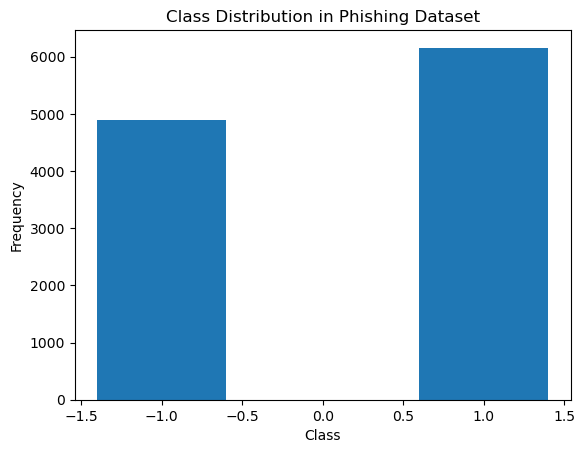

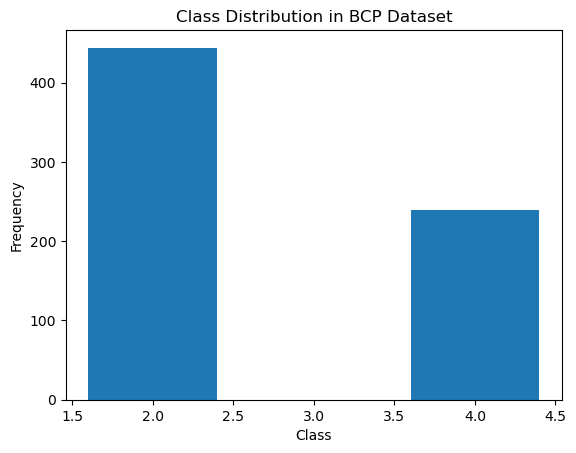

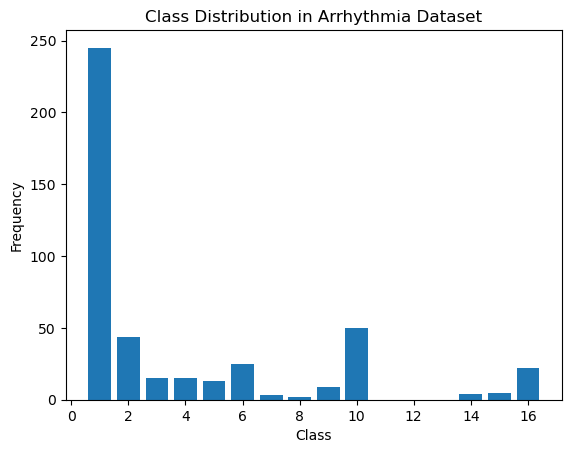

In [82]:
# look at how balanced each dataset is 

# phishing
class_counts_phishing = phishing_df['class'].value_counts()

plt.bar(class_counts_phishing.index, class_counts_phishing.values)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in Phishing Dataset")
plt.show()

# bcp
class_counts_phishing = bcp_df['class'].value_counts()

plt.bar(class_counts_phishing.index, class_counts_phishing.values)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in BCP Dataset")
plt.show()

# arrhythmia
class_counts_phishing = arrhythmia_df['class'].value_counts()

plt.bar(class_counts_phishing.index, class_counts_phishing.values)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in Arrhythmia Dataset")
plt.show()


Firstly, replace all question marks with NaN values for readability. There are many missing values, especially in the arrhythmia dataset. Two methods can be used to replace missing values. The choice between using the mode or mean for imputing missing values depends on the type of variable and the distribution of values. The mode is appropriate for categorical variables, while the mean is appropriate for normally distributed continuous variables. In this example, I looked through each column in the three dataframes independantly, and then decided which columns were most likely categorical or continuous. I would set the data type as int for categorical, and float for continuous. 

I loop through each column in each dataframe, and filled in missing values denoted by NaN with the mean or mode value of the column depending on if the column data is numeric or categorical. Columns with more than 50% of data as missing values are dropped as there isn't enough data to infer an accurate mean or mode.

### Question 2: Implement (1) a decision stump, (2) an unpruned decision tree, (3) a pruned decision tree. Apply (1)-(3) on each dataset. You can use scikit-learn packages. You can use pre-pruning and / or post-pruning techniques as your pruning strategy to obtain the pruned decision tree. Explain the pruning techniques you used.

In [83]:
# decision stump
# max depth is = 1

# collect cross-validation scores for task 4
cv_scores_stump = []

# store accuracies for each dataset
stump_accuracies = []

for df in dfs:
    X = df.drop(["class"], axis=1)
    y = df["class"]

    # split dataset into training and testing sets
    # hyperparameters: training and testing split percentage
    # random state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # create a decision stump model
    model = DecisionTreeClassifier(max_depth=1, criterion="entropy")

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = model.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    stump_accuracies.append(accuracy)
    
    # get cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_const)
    cv_scores_stump.append(cv_scores)
    
    '''
    # find a way to print this out as multiple graphs
    graph = graphviz.Source(tree.export_graphviz(model, out_file=None))
    graph.render("model")
    print(tree.plot_tree(model))
    '''
    
print("Accuracy:", stump_accuracies)


Accuracy: [0.8809164908049443, 0.9219512195121952, 0.5735294117647058]


/Users/tarineccleston/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


In [84]:
# unpruned decision tree
# don't specify max depth
# the tree stops growing as the impurity of the split (measured by entropy)
# does not decrease by a certain threshold

# collect cross-validation scores for task 4
cv_scores_unpruned_tree = []

# store accuracies for each dataset
unpruned_tree_accuracies = []

for df in dfs:
    X = df.drop(["class"], axis=1)
    y = df["class"]

    # split dataset into training and testing sets
    # hyperparameters: training and testing split percentage
    # random state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # create a decision tree model with no stopping conditions
    model = DecisionTreeClassifier(criterion="entropy")

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = model.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    unpruned_tree_accuracies.append(accuracy)
    
    # get cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_const)
    cv_scores_unpruned_tree.append(cv_scores)
    
    '''
    # find a way to print this out as multiple graphs
    graph = graphviz.Source(tree.export_graphviz(model, out_file=None))
    graph.render("model")
    print(tree.plot_tree(model))
    '''
    
print("Accuracy:", unpruned_tree_accuracies)

/Users/tarineccleston/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: [0.9562858004220681, 0.9560975609756097, 0.6397058823529411]


In [85]:
# pre-pruned decision tree
# manually tweak the max depth (stopping condition), where setting the max depth is a pre-pruning technique
# find the max depth which allows for the "best" accuracy for all datasets

# collect cross-validation scores for task 4
cv_scores_pruned_tree = []

# store accuracies for each dataset
pruned_tree_accuracies = []

for df in dfs:
    X = df.drop(["class"], axis=1)
    y = df["class"]

    # split dataset into training and testing sets
    # hyperparameters: training and testing split percentage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # create a decision tree model
    model = DecisionTreeClassifier(max_depth = 7)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = model.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    pruned_tree_accuracies.append(accuracy)
    
    # get cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_const)
    cv_scores_pruned_tree.append(cv_scores)

    '''
    # find a way to print this out as multiple graphs
    graph = graphviz.Source(tree.export_graphviz(model, out_file=None))
    graph.render("model")
    print(tree.plot_tree(model))
    '''
    
print("Accuracy:", pruned_tree_accuracies)

Accuracy: [0.934880916490805, 0.9414634146341463, 0.7205882352941176]


/Users/tarineccleston/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Pre-pruning techniques involve setting constraints on the growth of the decision tree before the tree is built. One common pre-pruning technique is to set the maximum depth of the decision tree, which limits the number of splits that can be made from the root node to any leaf node. This can be seen as an input max_depth, to the function which creates our classifier (DecisionTreeClassifier). In this example, the unpruned decision tree doesn't specify a max depth, and will continue to grow until the impurity of the split (measured by entropy) of a particular branch does not decrease by a certain threshold. In the pruned decision tree, I manually trialed several different max_depths until I found that a max_depth of 7 was ideal and provided a good balance of complexity and accuracy.

By limiting the depth of the tree, pre-pruning can prevent the model from fitting the training data too closely and becoming overfit. This can lead to better generalization performance on new, unseen data. The accuracy on the unpruned and pre-pruned decision trees are roughly similar for the phishing and BCP datasets, however the pre-pruned tree has a greater accuracy than the unpruned tree for the arrythmia dataset. This is because the unpruned decision tree is overfit to the dataset, and doesn't have as good performance on new unseen test data.

Limiting the depth of the tree by pre-pruning can reduce the number of splits that need to be evaluated during the training process, which can speed up the training time. The maximum depth hyperparameter must be tuned to the specific dataset, which can be time-consuming and requires expertise. Which leads us onto the next question...

### Question 3: Use a proper way to select your hyperparameters. Explain how you did it. Explain the observation you got from different datasets, and discuss the possible reason.

In [86]:
# pre-pruned decision tree
# automatically find the best hyperparameters using GridSearchCV
# the best hyperparameters 

# store accuracies for each dataset
opt_pruned_tree_accuracies = []

best_params = []

# hyperparameters to fine-tune
dt_params = {
    'max_depth': [2, 4, 6, 8, 10, 20, 30, None], # maximum depth of the tree, can help prevent overfitting
    'min_samples_split': [2, 5, 10], # the minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4] # the minimum number of samples required to be at a leaf node.
}


for df in dfs:
    X = df.drop(["class"], axis=1)
    y = df["class"]

    # split dataset into training and testing sets
    # hyperparameters: training and testing split percentage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # create a decision tree model
    model = DecisionTreeClassifier()

    # GridSearchCV for each classifier
    dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=1), dt_params, cv=cv_const)

    # Train the fine-tuned models
    dt_grid.fit(X_train, y_train)

    # get the best models 
    dt_best = dt_grid.best_estimator_
    print("Pre-pruned Decision Tree Best Params: " + str(dt_grid.best_params_))
    
    # evaluate the model
    # make predictions on the testing data
    y_pred = dt_best.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of Pre-pruned Decision Tree: ", accuracy)

    '''
    # find a way to print this out as multiple graphs
    graph = graphviz.Source(tree.export_graphviz(model, out_file=None))
    graph.render("model")
    print(tree.plot_tree(model))
    '''

Pre-pruned Decision Tree Best Params: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy of Pre-pruned Decision Tree:  0.9596020500452216
Pre-pruned Decision Tree Best Params: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 10}
Accuracy of Pre-pruned Decision Tree:  0.9512195121951219


/Users/tarineccleston/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Pre-pruned Decision Tree Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy of Pre-pruned Decision Tree:  0.6691176470588235


We are only concerned with prepruned decision trees for this example.

Hyperparameter tuning is the process of finding the best hyperparameters for a machine learning model. Grid search is a common brute-force method for hyperparameter tuning where a predefined hyperparameter space is exhaustively searched. The GridSearchCV function in Python's scikit-learn library can be used to perform grid search. The resulting object's best_estimator_ attribute can be utilized to access the model with the best set of hyperparameters discovered during the search.

Firstly, choose common hyperparameters in decision trees such as max_depth, min_samples_split and min_samples_leaf.
- Max_depth: the maximum depth a decision tree can reach
- Min_samples_split: a hyperparameter in decision tree algorithms that controls the minimum number of samples required to split an internal node. 
- Min_samples_leaf: a hyperparameter for decision tree algorithms in scikit-learn that specifies the minimum number of samples required to be at a leaf node.

Create a test grid using a range of values for each hyperparameter. Split the data into training and testing. Then create the decision tree classifier with no default hyperparameters, then create a search grid for the bare decision tree model using different combinations of hyperparameters. Then train each model in the search grid using the training set using 10-fold cross-validation.

Cross-validation is a statistical technique used to evaluate the performance of a machine learning model. In this example, we divide our training dataset into 10 subsets, train the model on one subset or fold, and then evaluate it on the remaining 9 folds. This process is repeated for each fold, and the average performance across all folds is used as the final evaluation metric. The primary goal of cross-validation is to assess how well the model will generalize to new, unseen data. By evaluating the model on multiple subsets of the data, it helps to reduce the risk of overfitting, which occurs when the model performs well on the training data but poorly on new data

Once all our models in the grid search have been evaluated, we can then find the one which performs the best overall in accuracy and F1-score. From this model, we can finally extract the most optimal hyperparameter values and use that to build our new model.

Observations

- Phishing: The best hyperparameters of the phishing dataset shows that the model is overfitted even though the accuracy is quite high at 95%. The max depth of the decision tree is 30, with a minimum sample leaf of 1, and min sample split of 2. The model learns the noise and specificities in the training data instead of the underlying patterns. Although the dataset is quite balance, there are many factors which result in overfitting, due to the categorical nature of the phishing data, it is safe to assume the possible reasons could be due to too many irrelevant features or insufficient training data. 

- BCP: The best hyperparameters and testing accuracy show that the model is well-fitted to the BCP datset, with a max depth of 6, min samples lead of 6, min samples split of 10 and test accuracy of 95%. Looking at the class histogram in task 1, the dataset is quite balanced, there also appears to be sufficient data and relevant features which correlate to the target classes.

- Arrythmia: The best max depth of the arrythmia dataset is 10 and min_samples_leaf at 1, and the corresponding test accuracy is 67%. This means that the accuracy doesn't increase dramatically as we increase our tree depth. This is proven through manually adjusting the max depth in task 2 for the prepruned decision tree. Looking at the dataset, the lack of accuracy could be due to having too many features (279) in the dataset. This is known as the curse of dimensionality, where the number of features becomes too large compared to the number of samples in the dataset. Having too many features can lead to overfitting, where the model learns the noise and specificities in the training data instead of the underlying patterns. This can result in poor generalization to new data, leading to low accuracy. Additionally, there the dataset is imbalanced as class=1 is much more prevalent in the data. An imbalanced dataset can result in an inaccurate model because the model can be biased towards the majority class, leading to poor predictions for the minority classes such as 2-16.

### Question 4: Compare the three methods used in task 2 and determine if any are performing significantly worse on each dataset. Report the p-value for the significance tests. Explain why the worst method performs worse than others.

In [118]:
# use cross validation scores from Question 2

p_value_stump_unpruned = []
p_value_stump_prepruned = []
p_value_pruned_prepruned = []

# find p_values for each dataset and comparisons
for i in range(0, 3):
    p_value_stump_unpruned.append(ttest_rel(cv_scores_stump[i], cv_scores_unpruned_tree[i])[1])
    p_value_stump_prepruned.append(ttest_rel(cv_scores_stump[i], cv_scores_pruned_tree[i])[1])
    p_value_pruned_prepruned.append(ttest_rel(cv_scores_unpruned_tree[i], cv_scores_pruned_tree[i])[1])

# Create the table data
table_data = [    ['Decision Stump vs Unpruned Decision Tree', p_value_stump_unpruned[0], p_value_stump_unpruned[1], p_value_stump_unpruned[2]],
    ['Decision Stump vs Prepruned Decision Tree', p_value_stump_prepruned[0], p_value_stump_prepruned[1], p_value_stump_prepruned[2]],
    ['Pruned Decision Tree vs Unpruned Decision Tree', p_value_pruned_prepruned[0], p_value_pruned_prepruned[1], p_value_pruned_prepruned[2]]
]

# Print the table
headers = ['Comparison', 'Phishing P-value', 'BCP P-value', 'Arrythmia P-value']
print(tabulate(table_data, headers=headers))

Comparison                                        Phishing P-value    BCP P-value    Arrythmia P-value
----------------------------------------------  ------------------  -------------  -------------------
Decision Stump vs Unpruned Decision Tree               1.40448e-09     0.00811137          0.0900014
Decision Stump vs Prepruned Decision Tree              1.3566e-09      0.0382215           6.46734e-05
Pruned Decision Tree vs Unpruned Decision Tree         1.26378e-06     0.44427             0.0087428


A general rule of thumb is that a p-value of more than 0.05 means we can accept the null hypothesis, less than 0.05 means we can reject the null hypothesis. The null hypothesis in this situation is the first model in the comparison performs better than the second model to predict new unseen data.

In this case, the unpruned and pruned decision trees both perform better than the decision stump, this is because the datasets which we are given rely on multiple features to predict the class, and the stump just utilises one feature, whereas the unpruned and pruned decision trees can analyses multiple features to predict the class. This could be proven by the p-values significantly below 0.05 across the board for the first and second rows. 

Looking at the pruned vs unpruned decision tree p-values, it is clear that the pruned decision tree performs much better than the unpruned decision tree ONLY for the BCP dataset as this comparison has a p-value of 0.444. From Question 3, the best max depth for the BCP dataset model is 6, and in this example, the prepruned max depth is 7. This is because the pruned decision tree is well-fitted to the BCP dataset, as the best hyperparameters such as max depth and min sample split seem reasonable, and the dataset is well balanced. However, in the same model comparison, the p-values for the phishing and arrythmia datasets both have very low values suggesting that the unpruned decision tree performs better than the pruned decision tree. It is already established that the optimum phishing trained model is overfitted with a max depth of 30, therefore pruning the decision tree to a max depth of 7 would result in worse performance.

It seems like an pruned decision tree performas better over the unpruned decision tree for the arrythmia dataset. The best max depth for this dataset is between 10-20 as shown in Question 3, whereas the unpruned decision tree is compared to the pruned decision tree with a max depth of 7 for this p-value calculation. As discussed before, both models provide a lack of accuracy due to the number of features compared to the number of samples in the dataset. Having too many features can lead to overfitting, where the model learns the noise and specificities in the training data instead of the underlying patterns. 

In summary, the choice of model really depends on the characteristics of a dataset. 


### Question 5: Use a pruning strategy (could be single or a combination of pruning techniques) that is different from what you've used in task 2. For example, if you use pre-pruning in task 2, then you need to use post-pruning or a combining of pre-pruning or post-pruning here. If you use maximum tree depth in task 2, you can't use the minimum data points in each leaf as the only pruning technique to control the tree size in task 5. This is because, in principle, they are similar techniques. Compare the effects of the two different pruning strategies on the three datasets. Explain your findings and discuss the possible reason.

Question 5: use post pruning method and compare that to task 2

In [ ]:
# pre-pruned decision tree
# manually tweak the max depth (stopping condition), where setting the max depth is a pre-pruning technique
# find the max depth which allows for the "best" accuracy for all datasets

# collect cross-validation scores for task 4
cv_scores_pruned_tree = []

# store accuracies for each dataset
pruned_tree_accuracies = []

for df in dfs:
    X = df.drop(["class"], axis=1)
    y = df["class"]

    # split dataset into training and testing sets
    # hyperparameters: training and testing split percentage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # create a decision tree model
    model = DecisionTreeClassifier(max_depth = 7)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = model.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    pruned_tree_accuracies.append(accuracy)
    
    # get cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_const)
    cv_scores_pruned_tree.append(cv_scores)

    '''
    # find a way to print this out as multiple graphs
    graph = graphviz.Source(tree.export_graphviz(model, out_file=None))
    graph.render("model")
    print(tree.plot_tree(model))
    '''
    
print("Accuracy:", pruned_tree_accuracies)